# 1 To collect training data, start vrep, load myrobo.ttt, hit start simulation
# 2 Run two cells below until data size is about 800 
### (that should be two full laps).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import vrep # access all the VREP elements
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

def echo(txt):
    sys.stdout.write('\r {}'.format(txt))
    sys.stdout.flush()
    
def getNumTrainParms(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

def preprocess(image):
    trgRes = (128, 128)
    img = np.array(image, dtype = np.uint8)
    img.resize([resolution[0], resolution[1], 3])
#     print('Camera res: {}'.format(resolution))
#     print('Target res: {}'.format(trgRes))
    img = np.flip(img, axis=0)
    img = cv2.resize(img, dsize=trgRes, interpolation=cv2.INTER_AREA)
    return img

def control(rs, ms, ls, clientID, r_motor_handle, l_motor_handle, speed):
    if ms[-1] < 12:
        if rs[-1] > ls[-1]:
            right_v = 0.1*speed
            left_v = 1.5*speed
            err_code = vrep.simxSetJointTargetVelocity(clientID, r_motor_handle, right_v, vrep.simx_opmode_streaming)
            err_code = vrep.simxSetJointTargetVelocity(clientID, l_motor_handle, left_v, vrep.simx_opmode_streaming)
#             echo('Left_sens: {:.4f} Mid_sens: {:.4f} Right_sens: {:.4f}'.format(ls[-1], ms[-1], rs[-1]))
        if ls[-1] > rs[-1]:
            right_v = 1.5*speed
            left_v = 0.1*speed
            err_code = vrep.simxSetJointTargetVelocity(clientID, l_motor_handle, left_v, vrep.simx_opmode_streaming)
            err_code = vrep.simxSetJointTargetVelocity(clientID, r_motor_handle, right_v, vrep.simx_opmode_streaming)
#             echo('Left_sens: {:.4f} Mid_sens: {:.4f} Right_sens: {:.4f}'.format(ls[-1], ms[-1], rs[-1]))
    if ms[-1] > 10:
        err_code = vrep.simxSetJointTargetVelocity(clientID, r_motor_handle, speed, vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID, l_motor_handle, speed, vrep.simx_opmode_streaming)
#         echo('Left_sens: {:.4f} Mid_sens: {:.4f} Right_sens: {:.4f}'.format(ls[-1], ms[-1], rs[-1]))
        right_v = speed
        left_v = speed
    return left_v, right_v

In [7]:
speed = 8.0

vrep.simxFinish(-1) # just in case, close all opened connections
clientID = vrep.simxStart("127.0.0.1", 19999, True, True, 5000, 5) # start a connection
if clientID != -1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

err_code, l_motor_handle = vrep.simxGetObjectHandle(clientID, "bubbleRob_leftMotor", vrep.simx_opmode_blocking)
err_code, r_motor_handle = vrep.simxGetObjectHandle(clientID, "bubbleRob_rightMotor", vrep.simx_opmode_blocking)
err_code, camera = vrep.simxGetObjectHandle(clientID, "Vision_sensor", vrep.simx_opmode_blocking)
err_code, R_cam_hdl = vrep.simxGetObjectHandle(clientID, "R_cam", vrep.simx_opmode_blocking)
err_code, L_cam_hdl = vrep.simxGetObjectHandle(clientID, "L_cam", vrep.simx_opmode_blocking)
err_code, M_cam_hdl = vrep.simxGetObjectHandle(clientID, "M_cam", vrep.simx_opmode_blocking)

# get some output from cameras for the first time to initialize them:
err_code, resolution, image = vrep.simxGetVisionSensorImage(clientID, camera, 0, vrep.simx_opmode_streaming)
err_code, resolution, R_cam_im = vrep.simxGetVisionSensorImage(clientID, R_cam_hdl, 0, vrep.simx_opmode_streaming)
err_code, resolution, L_cam_im = vrep.simxGetVisionSensorImage(clientID, L_cam_hdl, 0, vrep.simx_opmode_streaming)
err_code, resolution, M_cam_im = vrep.simxGetVisionSensorImage(clientID, M_cam_hdl, 0, vrep.simx_opmode_streaming)

err_code, d20RW_hdl = vrep.simxGetDistanceHandle(clientID, "L_19", vrep.simx_opmode_blocking)
err_code, d19RW_hdl = vrep.simxGetDistanceHandle(clientID, "L_20", vrep.simx_opmode_blocking)
err_code, d20LW_hdl = vrep.simxGetDistanceHandle(clientID, "R_19", vrep.simx_opmode_blocking)
err_code, d19LW_hdl = vrep.simxGetDistanceHandle(clientID, "R_20", vrep.simx_opmode_blocking)

err_code, d19RW = vrep.simxReadDistance(clientID, d19RW_hdl, vrep.simx_opmode_streaming)
err_code, d19LW = vrep.simxReadDistance(clientID, d19LW_hdl, vrep.simx_opmode_streaming)
err_code, d20RW = vrep.simxReadDistance(clientID, d20RW_hdl, vrep.simx_opmode_streaming)
err_code, d20LW = vrep.simxReadDistance(clientID, d20LW_hdl, vrep.simx_opmode_streaming)


time.sleep(1)

T, ms, ls, rs, LEFT_V, RIGHT_V = [],[],[],[],[],[]
t = time.time() #record the initial time

err_code = vrep.simxSetJointTargetVelocity(clientID, l_motor_handle, speed, vrep.simx_opmode_streaming)
err_code = vrep.simxSetJointTargetVelocity(clientID, r_motor_handle, speed, vrep.simx_opmode_streaming)
IMG = []
while (time.time() - t) < 600:
    err_code, resolution, image = vrep.simxGetVisionSensorImage(clientID, camera, 0, vrep.simx_opmode_buffer)
    err_code, resolution, R_cam_im = vrep.simxGetVisionSensorImage(clientID, R_cam_hdl, 0, vrep.simx_opmode_buffer)
    err_code, resolution, L_cam_im = vrep.simxGetVisionSensorImage(clientID, L_cam_hdl, 0, vrep.simx_opmode_buffer)
    err_code, resolution, M_cam_im = vrep.simxGetVisionSensorImage(clientID, M_cam_hdl, 0, vrep.simx_opmode_buffer)
#     err_code, d19RW = vrep.simxReadDistance(clientID, d19RW_hdl, vrep.simx_opmode_streaming)
#     err_code, d19LW = vrep.simxReadDistance(clientID, d19LW_hdl, vrep.simx_opmode_streaming)
#     err_code, d20RW = vrep.simxReadDistance(clientID, d20RW_hdl, vrep.simx_opmode_streaming)
#     err_code, d20LW = vrep.simxReadDistance(clientID, d20LW_hdl, vrep.simx_opmode_streaming)
    ls.append(np.mean(L_cam_im))
    rs.append(np.mean(R_cam_im))
    ms.append(np.mean(M_cam_im))
    
    T.append(time.time() - t)
    
    err_code, resolution, image = vrep.simxGetVisionSensorImage(clientID, camera, 0, vrep.simx_opmode_buffer)
    IMG.append(preprocess(image))
    left_v, right_v = control(rs, ms, ls, clientID, r_motor_handle, l_motor_handle, speed)
    LEFT_V.append(left_v)
    RIGHT_V.append(right_v)
    echo('data size: {}'.format(IMG.__len__()))
    
#     echo('Left_sens: {:.4f} Mid_sens: {:.4f} Right_sens: {:.4f}'.format(np.mean(L_cam_im), np.mean(M_cam_im), np.mean(R_cam_im)))
#     err_code, rm = vrep.simxGetJointTargetVelocity(clientID, r_motor_handle, vrep.simx_opmode_streaming)
#     err_code, lm = vrep.simxSetJointTargetVelocity(clientID, l_motor_handle, vrep.simx_opmode_streaming)
#     echo('Left_motor: {:.4f} Right_motor: {:.4f}'.format(lm, rm))
    
t = time.time()
while (time.time() - t) < 1:
    err_code = vrep.simxSetJointTargetVelocity(clientID, l_motor_handle, 0.0, vrep.simx_opmode_streaming)
    err_code = vrep.simxSetJointTargetVelocity(clientID, r_motor_handle, 0.0, vrep.simx_opmode_streaming)

img = np.array(image, dtype = np.uint8)

f = open('img.pickle', 'wb')
img.resize([resolution[0], resolution[1], 3])

img = np.flip(img, axis=0)
pickle.dump(img, f)
f.close()

img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_AREA)
print(img.shape)
plt.imshow(img)
plt.show()


Connected to remote API server
 data size: 176

KeyboardInterrupt: 

In [8]:
# rs = rs[:1251]
# ls = ls[:1251]
# ms = ms[:1251]
# RIGHT_V = RIGHT_V[:1251]
# LEFT_V = LEFT_V[:1251]
# IMG = IMG[:1251]

Text(0.5, 1.0, 'Time course of the training')

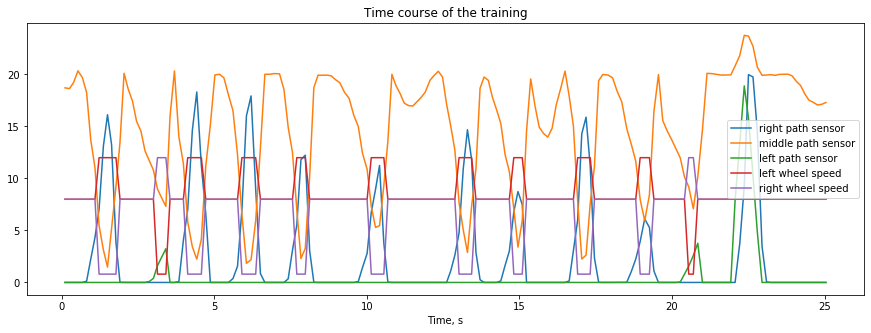

In [9]:
%matplotlib inline

plt.figure(figsize=(15,5))
plt.plot(T, rs, label='right path sensor')
plt.plot(T, ms, label='middle path sensor')
plt.plot(T, ls, label='left path sensor')
plt.plot(T, LEFT_V, label='left wheel speed')
plt.plot(T, RIGHT_V, label='right wheel speed')
plt.legend()
plt.xlabel ('Time, s')
plt.title('Time course of the training')

In [27]:
# Dump the training data to file:
f = open('robo_data_persp.pickle', 'wb')
pickle.dump({'IMG': IMG,
            'RIGHT_V': RIGHT_V, 
            'LEFT_V': LEFT_V},
            f)
f.close()

# Now upload robo_data_persp.pickle to the GPU cluster for model training

# You can replay the recorded data by running the cell below:

<IPython.core.display.Javascript object>


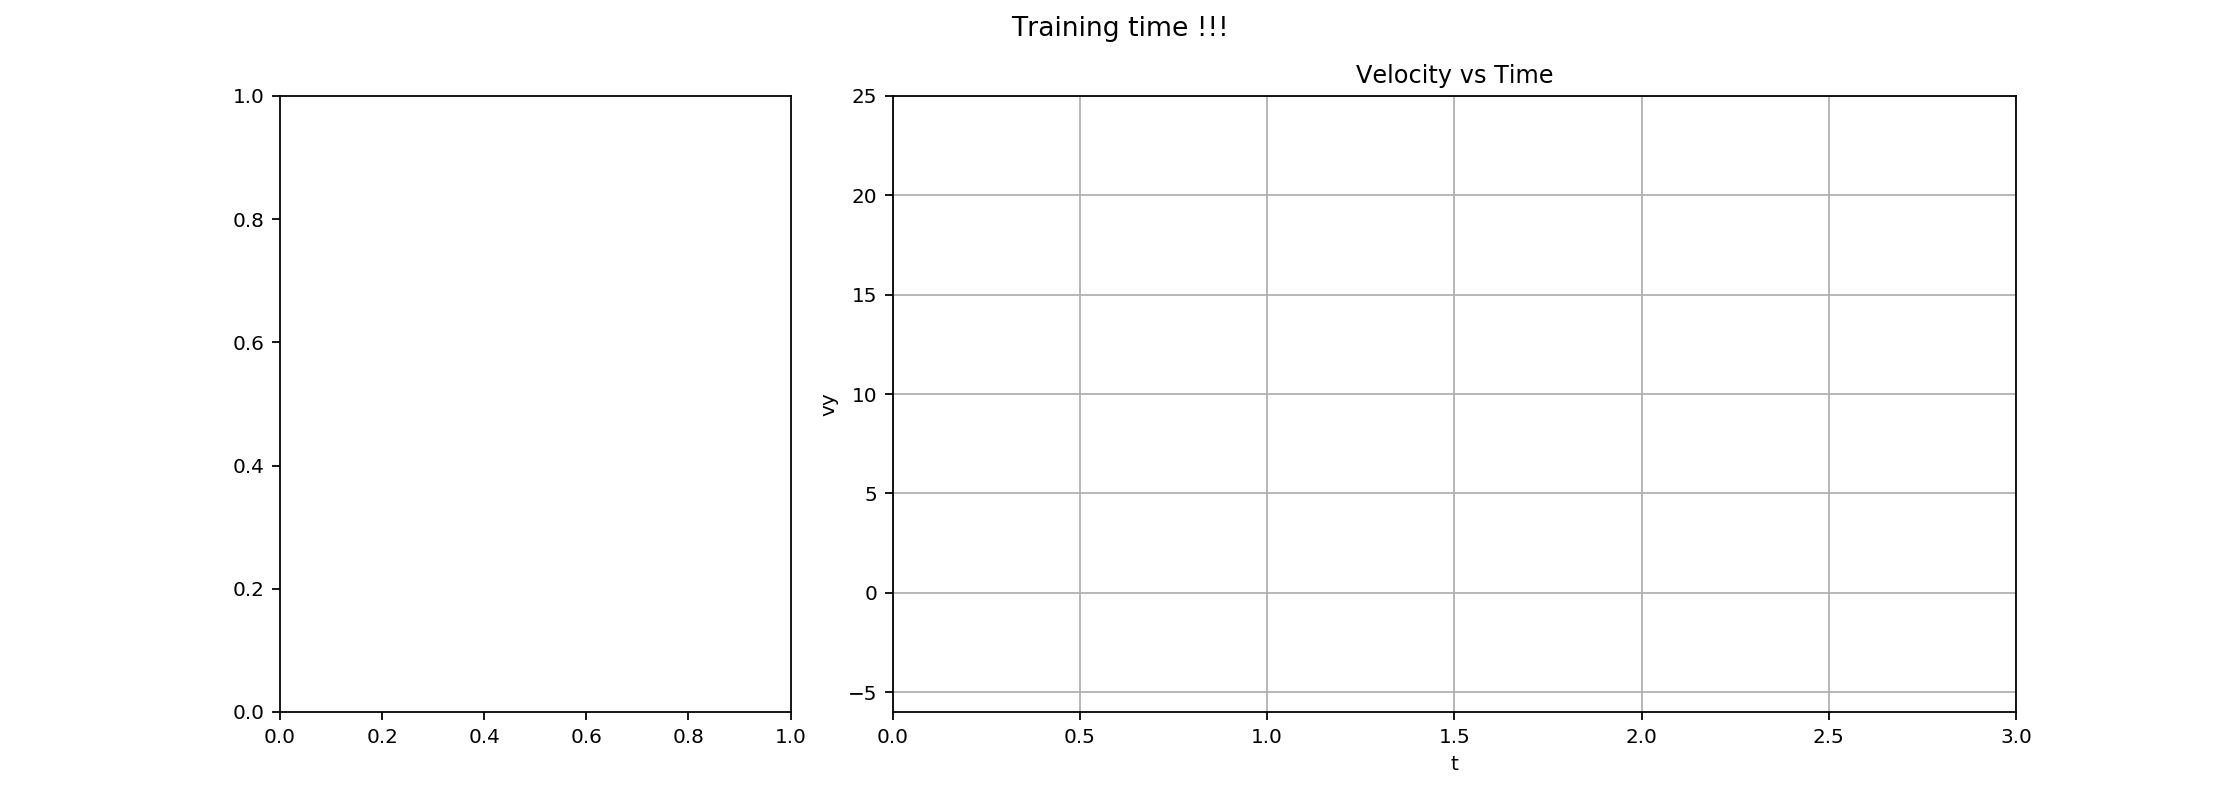

NameError: name 'IMG' is not defined

In [6]:
# Uncomment the next two lines if you want to save the animation
#import matplotlib
#matplotlib.use("Agg")

%matplotlib notebook
import numpy
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.animation as animation


# Sent for figure
font = {'size'   : 9}
matplotlib.rc('font', **font)

# Setup figure and subplots
f0 = figure(num = 0, figsize = (14, 5))#, dpi = 100)
f0.suptitle("Training time !!!", fontsize=12)
ax01 = subplot2grid((1, 3), (0, 0))
ax02 = subplot2grid((1, 3), (0, 1), colspan=2)
#tight_layout()

# Set titles of subplots
# ax01.set_title('Position vs Time')
ax02.set_title('Velocity vs Time')

# set y-limits
ax02.set_ylim(-6,25)

# sex x-limits
ax02.set_xlim(0,3.0)

# Turn on grids
ax02.grid(True)

# set label names
ax02.set_xlabel("t")
ax02.set_ylabel("vy")

# Data Placeholders
yp1=zeros(0)
yv1=zeros(0)
t=zeros(0)

# set plots
# p011, = ax01.plot(t,yp1,'b-', label="yp1")
p011 = ax01.imshow(IMG[0])
p021, = ax02.plot(t,yv1,'b-', label="right_sensor")
p022, = ax02.plot(t,yv1,'r-', label="left_sensor")
p023, = ax02.plot(t,yv1,'g-', label="middle_sensor")
p024, = ax02.plot(t,yv1,'y-', label="left_wheel")
p025, = ax02.plot(t,yv1,'k-', label="right_wheel")

# set lagends
# ax01.legend([p011], [p011.get_label()])
ax02.legend(loc='lower left')

# Data Update
xmin = 0.0
xmax = 3.0
x = 0.0
i = -1
ann = ax01.annotate("", (10,10), c='white')

def updateData(self):
    global i
    global rs, ms, ls
    global T
    global ax01
    global ann
    global LEFT_V, RIGHT_V
    
    i += 1
    
    p011.set_data(IMG[i])
    if i > 0:
        p021.set_data(T[:i],rs[:i])
        p022.set_data(T[:i],ls[:i])
        p023.set_data(T[:i],ms[:i])
        p024.set_data(T[:i],LEFT_V[:i])
        p025.set_data(T[:i],RIGHT_V[:i])

    if T[i] >= xmax:
        p021.axes.set_xlim(T[i]-xmax+1.0,T[i]+1.0)
        p022.axes.set_xlim(T[i]-xmax+1.0,T[i]+1.0)
        p023.axes.set_xlim(T[i]-xmax+1.0,T[i]+1.0)
    
    ann.remove()
    ann = ax01.annotate(T[i], (10,10), c='white')

    return p011, p021, p022, p023, p024, p025

# interval: draw new frame every 'interval' ms
# frames: number of frames to draw
interval = round(mean([i-j for i,j in zip(T[1:],T[:-1])])*1000, 0)
simulation = animation.FuncAnimation(f0, updateData, blit=False, frames=200, interval=interval, repeat=False)

# Uncomment the next line if you want to save the animation
# simulation.save(filename='sim.mp4',fps=30,dpi=300)

plt.show()


<IPython.core.display.Javascript object>


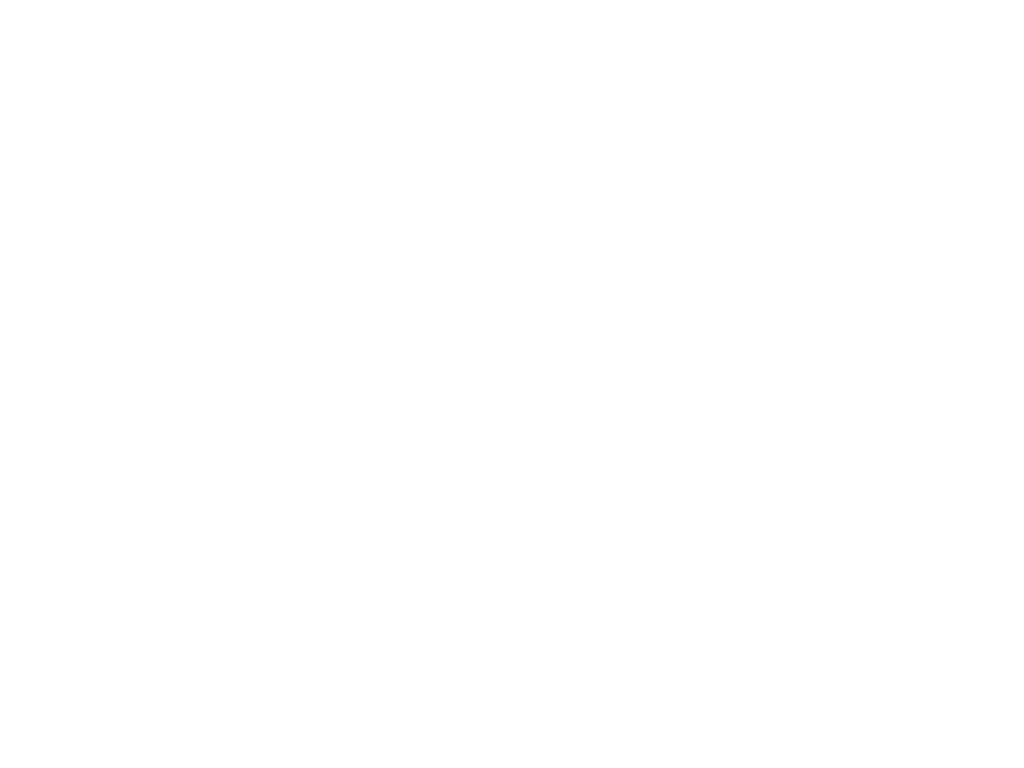

NameError: name 'IMG' is not defined

In [7]:
#  =============   DON'T DELETE: =========================   DON'T DELETE: =======================   DON'T DELETE: ============
# ARTIST ANIMATION:
import numpy
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.animation as animation
%matplotlib notebook

fig = plt.figure()
ims = []
for i in IMG[:100]:
    ims.append([plt.imshow(i, animated=True)])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()

#  =============   DON'T DELETE: =========================   DON'T DELETE: =======================   DON'T DELETE: ============

----------------------------------------------------------------------
# After the model is trained on the cluster, download the model checkpoint and dump1.pickle from the cluster
----------------------------------------------------------------------

# now let's load the model and see how it can 'see one step ahead':

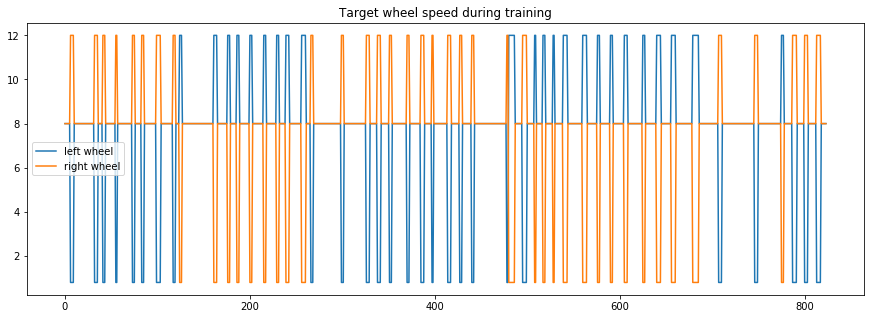

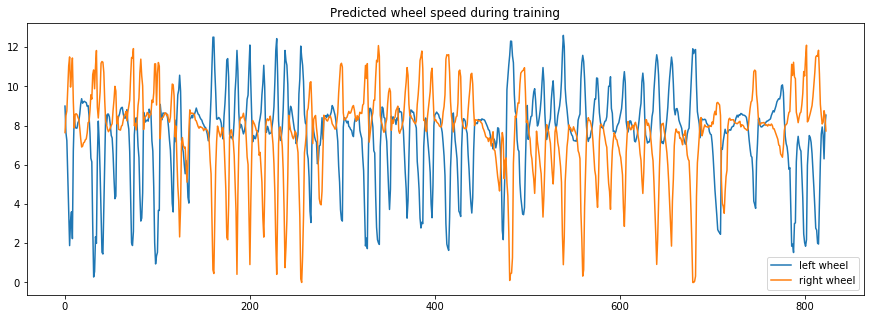

In [2]:
import pickle
fname = 'dump1.pickle'
f = open(fname, 'rb')
dat = pickle.load(f)
vinp = dat['vinp'].squeeze()
vout = dat['vout'].squeeze()
mi = dat['mi']
mo = dat['mo']
f.close()

%matplotlib inline
plt.figure(figsize=(15,5))
plt.title('Target wheel speed during training')
plt.plot(mi[:,0], label='left wheel')
plt.plot(mi[:,1], label='right wheel')
plt.legend()
plt.figure(figsize=(15,5))
plt.title('Predicted wheel speed during training')
plt.plot(mo[:,0], label='left wheel')
plt.plot(mo[:,1], label='right wheel')
plt.legend()

<IPython.core.display.Javascript object>


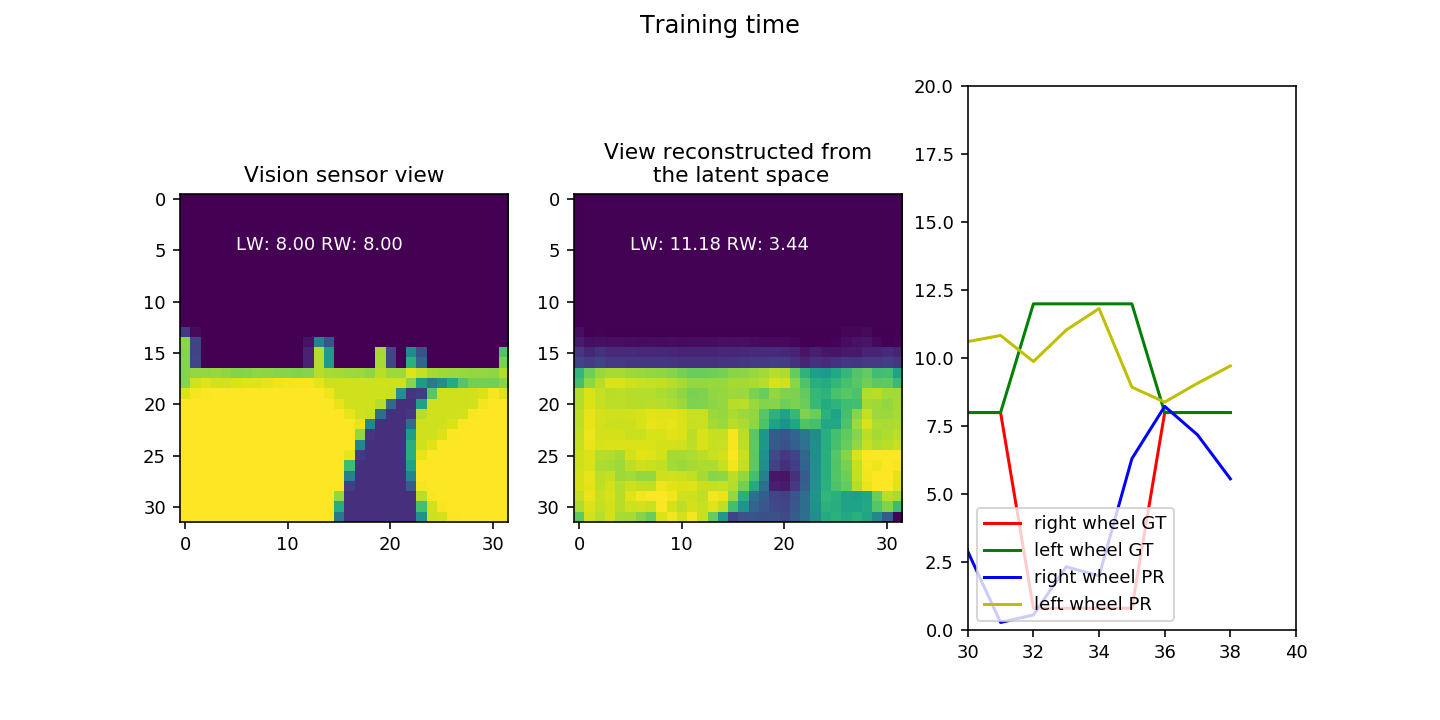

In [5]:


# Uncomment the next two lines if you want to save the animation
#import matplotlib
#matplotlib.use("Agg")

%matplotlib notebook
import numpy
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.animation as animation


# Sent for figure
font = {'size'   : 9}
matplotlib.rc('font', **font)

# Setup figure and subplots
f0 = figure(num = 0, figsize = (10, 5))#, dpi=200)
f0.suptitle("Training time", fontsize=12)
ax01 = subplot2grid((1, 3), (0, 0))
ax02 = subplot2grid((1, 3), (0, 1), colspan=1)
ax03 = subplot2grid((1, 3), (0, 2), colspan=1)
#tight_layout()

# Set titles of subplots
ax01.set_title('Vision sensor view')
ax02.set_title('View reconstructed from\n the latent space')

# set y-limits
ax03.set_ylim(0,20)

# sex x-limits
# ax02.set_xlim(0,3.0)

# Turn on grids
# ax02.grid(True)

# set label names
# ax02.set_xlabel("t")
# ax02.set_ylabel("vy")

# Data Placeholders
t=zeros(0)

# set plots
# p011, = ax01.plot(t,yp1,'b-', label="yp1")
p011 = ax01.imshow(vinp[0])
p021 = ax02.imshow(vout[0])
p030, = ax03.plot(list(range(3)), list(mi[0:3,0]),'r-', label="right wheel GT")
p031, = ax03.plot(list(range(3)), list(mi[0:3,1]),'g-', label="left wheel GT")
p032, = ax03.plot(list(range(3)), list(mo[0:3,0]),'b-', label="right wheel PR")
p033, = ax03.plot(list(range(3)), list(mo[0:3,1]),'y-', label="left wheel PR")

# set lagends
# ax01.legend([p011], [p011.get_label()])
ax03.legend(loc='lower left')

ann = ax01.annotate("", (10,10), c='white')
anp = ax02.annotate("", (10,10), c='white')

# Data Update
xmin = 0.0
xmax = 10.0
x = 0.0
i = -1

def updateData(self):
    global i
    global rs, ms, ls, mi, mo
    global ax01, ax02, ax03
    global ann, anp
    
    i += 1
    
    p011.set_data(vinp[i])
    p021.set_data(vout[i])
    if i > 0:
        p030.set_data(list(range(i)), list(mi[0:i,0]))
        p031.set_data(list(range(i)), list(mi[0:i,1]))
        p032.set_data(list(range(i)), list(mo[0:i,0]))
        p033.set_data(list(range(i)), list(mo[0:i,1]))

    if i >= xmax:
        p030.axes.set_xlim(i-xmax+1.0,i+1.0)
        p031.axes.set_xlim(i-xmax+1.0,i+1.0)
        p032.axes.set_xlim(i-xmax+1.0,i+1.0)
        p033.axes.set_xlim(i-xmax+1.0,i+1.0)

    anp.remove()
    ann.remove()
    anp = ax01.annotate('LW: {:.2f} RW: {:.2f}'.format(mi[i,1], mi[i,0]), (5,5), c='white')
    ann = ax02.annotate('LW: {:.2f} RW: {:.2f}'.format(mo[i,1], mo[i,0]), (5,5), c='white')

    return p011, p021, p030, p031, p032, p033

# interval: draw new frame every 'interval' ms
# frames: number of frames to draw
# interval = round(mean([i-j for i,j in zip(T[1:],T[:-1])])*1000, 0)
simulation = animation.FuncAnimation(f0, updateData, blit=False, frames=200, interval=150, repeat=False)

# Uncomment the next line if you want to save the animation
# simulation.save(filename='sim1.mp4',fps=30,dpi=300)

plt.show()


# The model predicts what it expects to see one step ahead and the motor output it will take.

----------------------------------------------------------------------
# Now we load the trained model and try to control the robot:
----------------------------------------------------------------------
## Hit the play button in Vrep and run the cells below to allow the model to control the robot:

In [10]:
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size):
        super(RNN, self).__init__()                  # extend the functionality of previously built classes.
        self.hidden_size = hidden_size
        self.cell_type = cell_type
        # YOU CAN USE EITHER LSTM, GRU OR VANILLA RNN
        if self.cell_type=='GRU':
            self.rnn_cell = nn.GRU(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=1)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='LSTM':
            self.rnn_cell = nn.LSTM(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=1)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='RNN':
            self.rnn_cell = nn.RNN(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=1)            # how many LSTM cells we want to stack (defalult=1)

        self.conv1 = nn.Conv2d(1, 7, kernel_size=3, padding=(1,1))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(7, 28, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.fc1 =   nn.Linear(1792, 100)
        self.fc2 =   nn.Linear(100, 10)
        self.fc3 =   nn.Linear(12, 2) # latent video (10) + motor (2) output from RNN to motor prediction
        self.fc4 =   nn.Linear(12, 64)
        self.us1 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us2 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us3 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us4 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.conv3 = nn.Conv2d(1, 10, 3, padding=1)
        self.conv4 = nn.Conv2d(10, 1, 3, padding=1)
        self.activate = nn.Tanh()
#         self.optimizer = optim.RMSprop(self.parameters(),
#                                        lr=0.001,
#                                        momentum=0.00,
#                                        weight_decay=0.000,
#                                        centered=False)
        self.optimizer = optim.Adam(self.parameters())        
        
    def forward(self, visual_input, motor_input, hidden):
        
        # visual pathway:
        out = F.relu(self.conv1(visual_input))
        out = self.pool1(out)
        out = F.relu(self.conv2(out)) # torch.Size([1367, 15, 58, 58])
        out = self.pool2(out)         # torch.Size([1367, 15, 28, 28])
        out = out.view(-1, out.size()[1]*out.size()[2]*out.size()[3]) # flatten
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        
        # concatenate visual pathway and motor input:
        out = torch.cat((out, motor_input), dim=1).unsqueeze_(1) # unsqueeze adds a dimension (for batch=1) inplace
        
        # run this combined input through an RNN cell (to predict the next visual input and motor state):
        out, hidden = self.rnn_cell(out, hidden)
        
        # predict motor output based on the latent representation:
        motor_output = F.relu(self.fc3(out.squeeze()))
        
        # reconstruct video from the latent representation:
        out1 = F.relu(self.fc4(out.squeeze()))
        out1 = out1.view(-1,1,8,8)
        out1 = self.us1(out1)
        out1 = F.relu(self.conv3(out1))
        out1 = self.us2(out1)
        out1 = F.relu(self.conv4(out1))

        return out1, motor_output, hidden

    def initHidden(self):
        if self.cell_type=='LSTM': # we initialize a 2-tuple of hidden states (hidden state, memory)
            return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        if self.cell_type=='GRU' or self.cell_type=='RNN': # we initialize a hidden state
            return torch.zeros(1, 1, self.hidden_size)

In [11]:
# we load either checkpoint 1 or checkpoint 2:

In [12]:
# load model and weights optimized on GPU:
input_size  = 12
hidden_size = 12
output_size = 12
cell_type = 'GRU'
rnn = RNN(cell_type, input_size, hidden_size, output_size)
rnn.load_state_dict(torch.load('checkpoint_1', map_location='cpu'))
torch.no_grad()

In [13]:
# get number of trainable parameters in the model:
getNumTrainParms(rnn)

184157

# Run
`python animation.py` 

In [14]:
def img_preproc(in_im, dsize=(32, 32), color=False):
    in_im = np.array(in_im, dtype = np.uint8)
    in_im.resize([resolution[0], resolution[1], 3])
    in_im = np.flip(in_im, axis=0)
    if color==False:
        in_im = cv2.resize(in_im, dsize=dsize, interpolation=cv2.INTER_AREA).transpose(2,0,1)[0,:,:]
        return torch.tensor(in_im, dtype=torch.float).view(1,1,dsize[0],dsize[1])
    else:
        in_im = np.array(top_cam_pic, dtype = np.uint8).reshape(resolution[0], resolution[1], 3)
        return in_im

def hit_rob(clientID, bRob_handle):    
    ret_code, _, _, _, _ = vrep.simxCallScriptFunction(clientID,
                                                       'bubbleRob',
                                                       vrep.sim_scripttype_childscript,
                                                       'perturb_func',
                                                       [bRob_handle],[],[],
                                                       bytearray(),
                                                       vrep.simx_opmode_blocking)
speed = 8.0

vrep.simxFinish(-1) # just in case, close all opened connections
clientID = vrep.simxStart("127.0.0.1", 19999, True, True, 5000, 5) # start a connection
if clientID != -1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

err_code, bRob_handle = vrep.simxGetObjectHandle(clientID, "bubbleRob", vrep.simx_opmode_blocking)
err_code, l_motor_handle = vrep.simxGetObjectHandle(clientID, "bubbleRob_leftMotor", vrep.simx_opmode_blocking)
err_code, r_motor_handle = vrep.simxGetObjectHandle(clientID, "bubbleRob_rightMotor", vrep.simx_opmode_blocking)
err_code, camera = vrep.simxGetObjectHandle(clientID, "Vision_sensor", vrep.simx_opmode_blocking)
err_code, top_cam = vrep.simxGetObjectHandle(clientID, "top_cam", vrep.simx_opmode_blocking)

# get some output from cameras for the first time to initialize them:
err_code, resolution, image = vrep.simxGetVisionSensorImage(clientID, camera, 0, vrep.simx_opmode_streaming)
err_code, resolution_tc, top_cam_pic = vrep.simxGetVisionSensorImage(clientID, top_cam, 0, vrep.simx_opmode_streaming)


# wait for the backend to come online:
time.sleep(1)

T, LEFT_V, RIGHT_V = [],[],[]
t = time.time() #record the initial time

# initialize hidden state:
hidden = rnn.initHidden()

# start rolling:
motor_input = torch.tensor([8.0, 8.0], dtype=torch.float).view(1,2)


err_code, resolution, image = vrep.simxGetVisionSensorImage(clientID, camera, 0, vrep.simx_opmode_buffer)
err_code, resolution_tc, top_cam_pic = vrep.simxGetVisionSensorImage(clientID, top_cam, 0, vrep.simx_opmode_buffer)
err_code = vrep.simxSetJointTargetVelocity(clientID, l_motor_handle, speed, vrep.simx_opmode_streaming)
err_code = vrep.simxSetJointTargetVelocity(clientID, r_motor_handle, speed, vrep.simx_opmode_streaming)

n = torch.rand((1,1,32,32))*150

while (time.time() - t) < 600:
    
#     add noise to visual input from 5 to 7 seconds into the simulation:
    if (time.time() - t) > 5 and (time.time() - t) < 7:
#         print('adding noise to visual input')
        visual_input = img_preproc(image) + n
        state = 'NOISE'
    else:
        visual_input = img_preproc(image)
        state = 'NOMINAL'
        
    if ((time.time() - t) > 2 and (time.time() - t) < 2.1) or ((time.time() - t) > 7 and (time.time() - t) < 7.1):
        hit_rob(clientID, bRob_handle)
        state = 'FORCE APPLIED'
    
    visual_output, motor_output, hidden = rnn(visual_input, motor_input, hidden)
    motor_input = motor_output.view(1,2)
    
    vo = visual_output.squeeze().detach().numpy()
    vi = visual_input.squeeze().detach().numpy()
    tc = img_preproc(top_cam_pic, dsize=(256, 256), color=True)
    with open('example', 'wb') as f:
        pickle.dump((vi, vo, tc, state), f)
    
    right_v = motor_output[0].item()
    left_v  = motor_output[1].item()
    err_code = vrep.simxSetJointTargetVelocity(clientID, r_motor_handle, right_v, vrep.simx_opmode_streaming)
    err_code = vrep.simxSetJointTargetVelocity(clientID, l_motor_handle, left_v, vrep.simx_opmode_streaming)
    
    err_code, resolution, image = vrep.simxGetVisionSensorImage(clientID, camera, 0, vrep.simx_opmode_buffer)
    err_code, resolution_tc, top_cam_pic = vrep.simxGetVisionSensorImage(clientID, top_cam, 0, vrep.simx_opmode_buffer)
    
    echo('Left_v: {:.4f} Right_v: {:.4f}'.format(left_v, right_v))

Connected to remote API server
 Left_v: 6.9563 Right_v: 8.20746

ValueError: cannot reshape array of size 0 into shape (256,256,3)

In [ ]:
%matplotlib notebook
import numpy
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.animation as animation

f0 = plt.figure()
ax01 = subplot2grid((1, 3), (0, 0))
i = 0
def upd_frame(self):
    global i
    global ax01
    p011 = ax01.imshow(IMG[i])
    i += 1
    return p011

for datt in IMG:
    simulation = animation.FuncAnimation(f0, upd_frame, blit=False, frames=200, interval=50, repeat=False)
plt.show()